# Get started

Node Classification

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

DGL은 backend로 pytorch tensorflow mxnet을 사용할 수 있다.([참조](https://docs.dgl.ai/en/0.4.x/install/backend.html) )

In [18]:
!pip install dgl
import dgl
from dgl import DGLGraph

dgl.load_backend('pytorch')

Using backend: pytorch


필요한 library : numpy

In [19]:
import numpy as np

# GNN 모델

Node representation.
DGL의 사용방법 2가지:
* nn.Module
* message passing방법

GraphSage : 
$$h_{N(v)}^{(l)} \gets AGGREGATE_k({h_u^{(l-1)}, \forall u \in N(v)})$$
$$h_v^{(l)} \gets \sigma(W^k \cdot CONCAT(h_v^{(l-1)}, h_{N(v)}^{(l)})),$$

where $N(v)$ is the neighborhood of node $v$ and $l$ is the layer Id.
$N(v)$ 는 노드 $v$의 이웃. $l$는 레이어 번호(Id).

GraphSage는 multi-레이어이다. 각 레이어에서 노드는 edge로 이어진 이웃 노드에 접근한다. 레이어가 k개이면, k와 k보다 작은 수 만큼 떨어진 node와의 관계를 본다. k만큼 멀리있는 노드를 k-hop이라고 한다. GraphSage의 output은 각 node의 representation이다.

<img src="https://github.com/zheng-da/DGL_devday_tutorial/raw/master/GNN.png" alt="drawing" width="600"/>

여기에선, DGL의 `nn` 모듈을 사용한다. `SAGEConv`가 `GraphSage`의 각 레이어에 들어가있다.

In [20]:
from dgl.nn.pytorch import conv as dgl_conv

class GraphSAGEModel(nn.Module):
    def __init__(self,
                 in_feats,
                 n_hidden,
                 out_dim,
                 n_layers,
                 activation,
                 dropout,
                 aggregator_type):
        super(GraphSAGEModel, self).__init__()
        self.layers = nn.ModuleList()

        # input layer
        self.layers.append(dgl_conv.SAGEConv(in_feats, n_hidden, aggregator_type,
                                         feat_drop=dropout, activation=activation))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.append(dgl_conv.SAGEConv(n_hidden, n_hidden, aggregator_type,
                                             feat_drop=dropout, activation=activation))
        # output layer
        self.layers.append(dgl_conv.SAGEConv(n_hidden, out_dim, aggregator_type,
                                         feat_drop=dropout, activation=None))

    def forward(self, g, features):
        h = features
        for layer in self.layers:
            h = layer(g, h)
        return h

다양한 `GraphConv`의 예제.
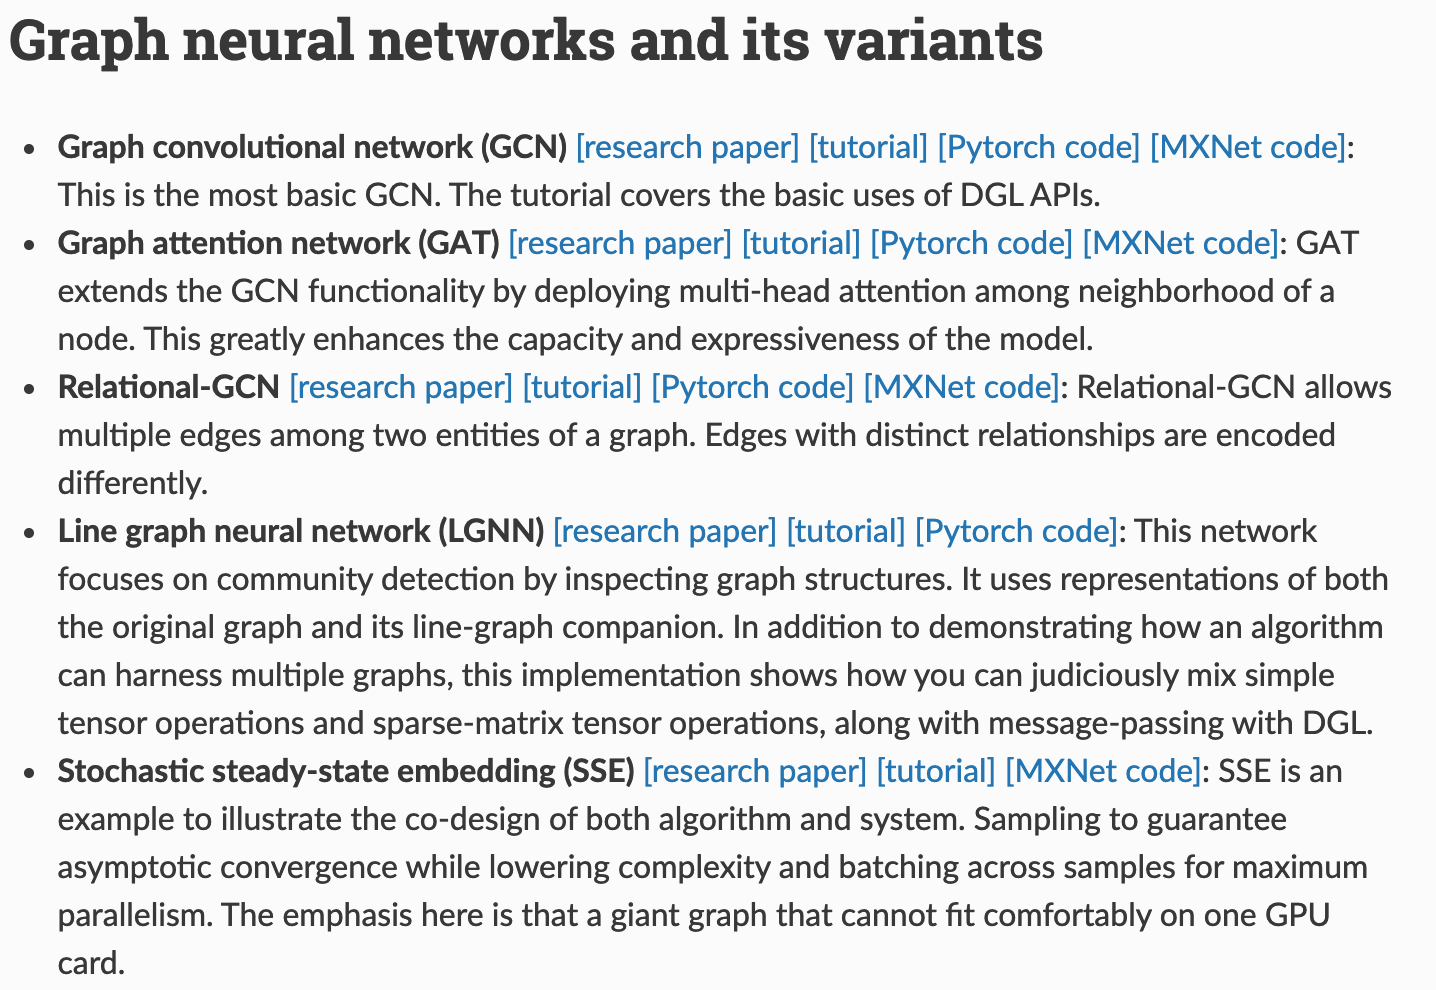

# 데이터셋

DGL안에 데이터셋이 많다. [참조](https://doc.dgl.ai/api/python/data.html#dataset-classes)

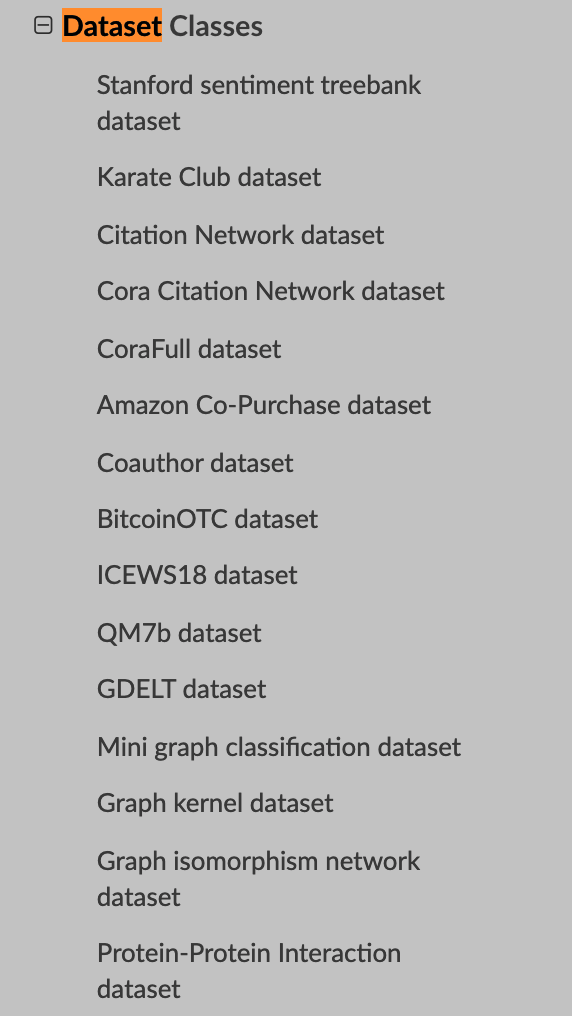

여기에선 Pubmed라는 논문인용 네트워크 데이터넷을 사용한다.

노드는 각 paper이고, edge는 인용된 두 논문을 이어준다. 19,717 논문(node)들과 88,651 edge가 있다. 각 node는 feature와 class를 가지고 있다(sparse bag-of-words).

In [21]:
from dgl.data import citegrh

# load and preprocess the pubmed dataset
data = citegrh.load_pubmed()

# sparse bag-of-words features of papers
features = torch.FloatTensor(data.features)     # 넘파이에서 파이토치 텐서로 변환
# the number of input node features
in_feats = features.shape[1]
# class labels of papers
labels = torch.LongTensor(data.labels)     # 파이토치 텐서로 변환
# the number of unique classes on the nodes.
n_classes = data.num_labels

Finished data loading and preprocessing.
  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000


네트워크(graph) 구조를 [NetworkX](https://networkx.github.io) 객체를 쓴다.

In [22]:
import networkx as nx
nx.selfloop_edges(data.graph)
data.graph.remove_edges_from(nx.selfloop_edges(data.graph)) #self-loop제거

In [23]:
g = DGLGraph(data.graph)
g.readonly() #오로지 더 빠르게 읽기 위해. 수정이 없는경우 사용. (메모리 절약)

# Semi-supervised node classification

모든 graph를 가지고 있으며, 각 node의 feature를 가지고 있고, 몇개만 class label이 있으며, 몇개는 없다. class label이 없는 node의 class를 예측한다. labeled node와 unlabeled node를 같이 학습한다.

<img src="https://github.com/zheng-da/DGL_devday_tutorial/raw/master/node_classify1.png" alt="drawing" width="200"/>


2층 GraphSage.

하이퍼파라미터

In [24]:
n_hidden = 64
n_layers = 2
dropout = 0.5
aggregator_type = 'gcn'

gconv_model = GraphSAGEModel(in_feats,
                             n_hidden,
                             n_classes,
                             n_layers,
                             F.relu,
                             dropout,
                             aggregator_type)

`GraphSage`는 DGLGraph객체와 node의 feature들을 input으로 받는다. output은 node embeddings이다. node embeddings로 cross entropy loss를 써서 훈련한다.



In [25]:
class NodeClassification(nn.Module):
    def __init__(self, gconv_model, n_hidden, n_classes):
        super(NodeClassification, self).__init__()
        self.gconv_model = gconv_model
        self.loss_fcn = torch.nn.CrossEntropyLoss()

    def forward(self, g, features, train_mask):
        logits = self.gconv_model(g, features)
        return self.loss_fcn(logits[train_mask], labels[train_mask])

classification정확도 함수

In [26]:
def NCEvaluate(model, g, features, labels, test_mask):
    model.eval()
    with torch.no_grad():
        logits = model.gconv_model(g, features)
        logits = logits[test_mask]
        test_labels = labels[test_mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == test_labels)
        return correct.item() * 1.0 / len(test_labels)

데이터 준비

In [27]:
# train/val/text split
train_mask = torch.BoolTensor(data.train_mask)
val_mask = torch.BoolTensor(data.val_mask)
test_mask = torch.BoolTensor(data.test_mask)

print("""----Data statistics------'
      #Classes %d
      #Train samples %d
      #Val samples %d
      #Test samples %d""" %
          (n_classes,
           data.train_mask.sum().item(),
           data.val_mask.sum().item(),
           data.test_mask.sum().item()))

----Data statistics------'
      #Classes 3
      #Train samples 60
      #Val samples 500
      #Test samples 1000


훈련

In [ ]:
model = NodeClassification(gconv_model, n_hidden, n_classes)

# 하이퍼파라미터
weight_decay = 5e-4
n_epochs = 30
lr = 1e-3

# 옵티마이저
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

dur = []
for epoch in range(n_epochs):
    model.train()
    
    loss = model(g, features, train_mask)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = NCEvaluate(model, g, features, labels, val_mask)
    print("Epoch {:05d} | Loss {:.4f} | Accuracy {:.4f}"
          .format(epoch, loss.item(), acc))

acc = NCEvaluate(model, g, features, labels, test_mask)
print("\nTest Accuracy {:.4f}".format(acc))

Epoch 00000 | Loss 1.0967 | Accuracy 0.4500
Epoch 00001 | Loss 1.1063 | Accuracy 0.4920
Epoch 00002 | Loss 1.0951 | Accuracy 0.5200
Epoch 00003 | Loss 1.0950 | Accuracy 0.5460
Epoch 00004 | Loss 1.1020 | Accuracy 0.5560
Epoch 00005 | Loss 1.0931 | Accuracy 0.5760
Epoch 00006 | Loss 1.0856 | Accuracy 0.5940
Epoch 00007 | Loss 1.0932 | Accuracy 0.6180
Epoch 00008 | Loss 1.0882 | Accuracy 0.6360
Epoch 00009 | Loss 1.0866 | Accuracy 0.6700
Epoch 00010 | Loss 1.0952 | Accuracy 0.6940
Epoch 00011 | Loss 1.0882 | Accuracy 0.7140
Epoch 00012 | Loss 1.0966 | Accuracy 0.7280
Epoch 00013 | Loss 1.0816 | Accuracy 0.7420
Epoch 00014 | Loss 1.0841 | Accuracy 0.7440
Epoch 00015 | Loss 1.0804 | Accuracy 0.7400
Epoch 00016 | Loss 1.0791 | Accuracy 0.7320
Epoch 00017 | Loss 1.0772 | Accuracy 0.7320
Epoch 00018 | Loss 1.0808 | Accuracy 0.7300
Epoch 00019 | Loss 1.0670 | Accuracy 0.7220
Epoch 00020 | Loss 1.0709 | Accuracy 0.7180
Epoch 00021 | Loss 1.0669 | Accuracy 0.7140
Epoch 00022 | Loss 1.0654 | Accu